# Model Prediction

RouteE models can be loaded from a large library of pre-trained models. Conventional gasoline (CV), hybrid electric (HEV), plug-in hybrid electric (PHEV), and battery electric (BEV) powertrain types are all available.

__A note on PHEVs__: Plug-in hybrids have two general operating modes 1) "Charge Depleting" or "EV" mode, where the vehicle relies only on energy from the battery to power the motor and 2) "Charge Sustaining" or "Hybrid" mode, where the vehicle operates like a typical parallel hybrid, using a combination of the combustion energy and electric motor for tractive effort and regenerative braking. Since the operating mode depends on battery state-of-charge and driver decisions, pre-trained RouteE-Powertrain models for both operating modes are provided for all PHEVs and it is up to the user to decide which is most appropriate for a particular application.

In [1]:
import nrel.routee.powertrain as pt

In [2]:
pt.list_available_models()

['2016_TOYOTA_Camry_4cyl_2WD',
 '2017_CHEVROLET_Bolt',
 '2010_Mazda_3_i-Stop',
 '2012_Ford_Focus',
 '2012_Ford_Fusion',
 '2016_AUDI_A3_4cyl_2WD',
 '2016_BMW_328d_4cyl_2WD',
 '2016_BMW_i3_REx_PHEV_Charge_Depleting',
 '2016_BMW_i3_REx_PHEV_Charge_Sustaining',
 '2016_CHEVROLET_Malibu_4cyl_2WD',
 '2016_CHEVROLET_Spark_EV',
 '2016_CHEVROLET_Volt_Charge_Depleting',
 '2016_CHEVROLET_Volt_Charge_Sustaining',
 '2016_FORD_C-MAX_(PHEV)_Charge_Depleting',
 '2016_FORD_C-MAX_(PHEV)_Charge_Sustaining',
 '2016_FORD_C-MAX_HEV',
 '2016_FORD_Escape_4cyl_2WD',
 '2016_FORD_Explorer_4cyl_2WD',
 '2016_HYUNDAI_Elantra_4cyl_2WD',
 '2016_HYUNDAI_Sonata_PHEV_Charge_Depleting',
 '2016_HYUNDAI_Sonata_PHEV_Charge_Sustaining',
 '2016_Hyundai_Tucson_Fuel_Cell',
 '2016_KIA_Optima_Hybrid',
 '2016_Leaf_24_kWh',
 '2016_MITSUBISHI_i-MiEV',
 '2016_Nissan_Leaf_30_kWh',
 '2016_TESLA_Model_S60_2WD',
 '2016_TOYOTA_Camry_4cyl_2WD',
 '2016_TOYOTA_Corolla_4cyl_2WD',
 '2016_TOYOTA_Highlander_Hybrid',
 '2016_Toyota_Prius_Two_FWD',


In [3]:
camry = pt.load_model("2016_TOYOTA_Camry_4cyl_2WD")

After loading a model, we can inspect it to see what features (and units) the model expects. 
RouteE Powertrain models can have multiple estimators under the hood which have been trained on different feature sets.
For example, there might be an estimator that takes just `speed` as a link feature and another that takes in `speed` and `grade`.
This can be useful if you have sparse data for one feature (like grade) but still want to predict energy consumption.

In [4]:
camry

========================================
Model Summary
--------------------
Vehicle description: 2016_TOYOTA_Camry_4cyl_2WD trained July 2024
Powertrain type: ICE
Number of estimators: 3
========================================
Estimator Summary
--------------------
Feature: speed_mph (mph)
Distance: distance (miles)
Target: gge (gallons gasoline)
Raw Predicted Consumption: 30.279 (miles/gallons gasoline)
Real World Predicted Consumption: 25.969 (miles/gallons gasoline)
Predict Method: RATE
========================================
Estimator Summary
--------------------
Feature: speed_mph (mph)
Feature: grade_percent (percent)
Distance: distance (miles)
Target: gge (gallons gasoline)
Raw Predicted Consumption: 30.289 (miles/gallons gasoline)
Real World Predicted Consumption: 25.977 (miles/gallons gasoline)
Predict Method: RATE
========================================
Estimator Summary
--------------------
Feature: speed_mph (mph)
Feature: grade_percent (percent)
Feature: turn_angle (degrees)
Distance: distance (miles)
Target: gge (gallons gasoline)
Raw Predicted Consumption: 30.364 (miles/gallons gasoline)
Real World Predicted Consumption: 26.041 (miles/gallons gasoline)
Predict Method: RATE
========================================

Now, let's predict energy consumption over a sample route.
RouteE Powertrain expects the inputs to be a pandas dataframe in which each row represents a road network link.
There is a sample route included with the package that we'll use for demonstration.

In [10]:
sample_route = pt.load_sample_route()
sample_route

,speed_mph,grade_dec,miles
0,7.632068,-0.008963,0.015469
1,6.329613,-0.047001,0.003516
2,12.248512,0.000000,0.003402
3,23.752604,-0.000463,0.019768
4,46.024926,-0.004641,0.038378
...,...,...,...
120,7.415272,-0.001339,0.006128
121,27.685268,-0.030748,0.023170
122,51.322545,-0.008490,0.028510
123,50.431920,-0.010533,0.028015


If we just pass in the links DataFrame without any other information, the model will assume we want to use all the features and in this case will look for an internal estimator with features to match all the columns.

Based on the model summary shown above, we do have an estimator that takes in the link features `speed_mph` and `grade_percent` with a distance of `distance` and so it will automatically select that estimator when we predict.

In [12]:
camry.predict(sample_route)

,gge
0,0.000882
1,0.000216
2,0.000149
3,0.000853
4,0.000906
...,...
120,0.000352
121,0.000660
122,0.000627
123,0.000616


If we want to use a different estimator, we can tell the predict method to only use a subset of the features. In this case, we'll tell the model to only use speed.

In [13]:
camry.predict(sample_route, feature_columns=["speed_mph"])

,gge
0,0.000939
1,0.000241
2,0.000158
3,0.000829
4,0.000982
...,...
120,0.000379
121,0.000895
122,0.000730
123,0.000717


## Model Visualization

There are a few different functions we can visualize what a model is predicting over a range of inputs.

The first is the `visualize_features` function that sweeps a feature over a range and plots the results.
In order to use this we first have to define what ranges the features should be considered.

In [19]:
feature_ranges = {
    "speed_mph": {"lower": 2, "upper": 100, "n_samples": 50},
    "grade_percent": {"lower": -20.0, "upper": 20.0, "n_samples": 50}
}

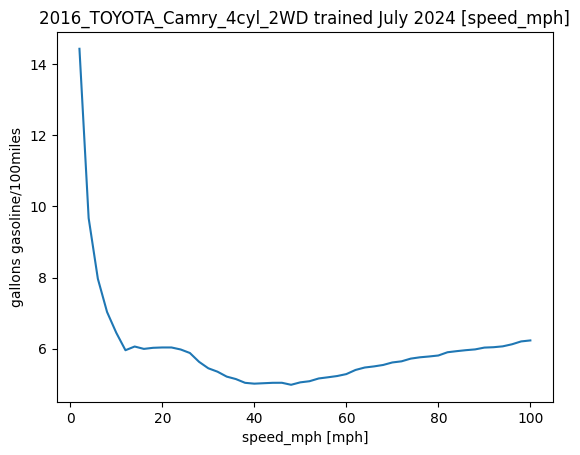

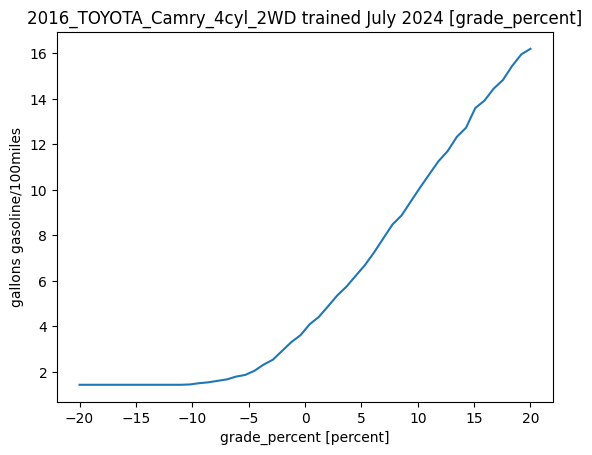

<Figure size 640x480 with 0 Axes>

In [20]:
results = pt.visualize_features(camry, feature_ranges)

We can also look at two features simultaneously with the `contour_plot` function. 

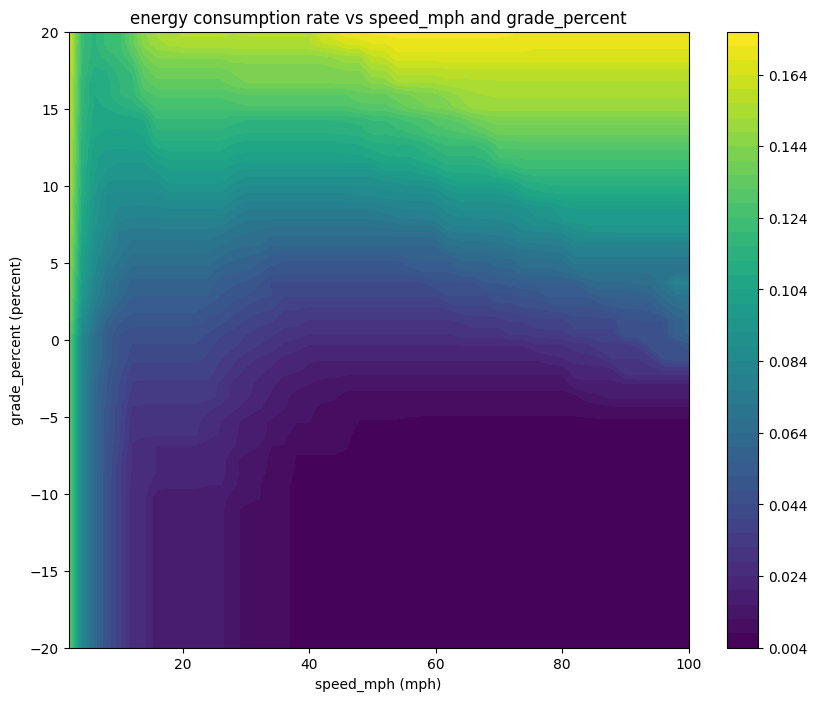

In [21]:
pt.contour_plot(camry, x_feature="speed_mph", y_feature="grade_percent", feature_ranges=feature_ranges)